In [1]:
import pandas as pd
import os

data_path = '/home/jovyan/work/data'
data_path = 'D:\\analise-airbnb-rentabilite\data'
df = pd.read_csv(os.path.join(data_path, 'listings_process.csv'), sep=',')
df.head()

C:\Users\hugue\AppData\Local\Temp\ipykernel_24740\3606472673.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_path, 'listings_process.csv'), sep=',')


,id,room_type,price,availability_365,longitude,latitude,property_type,room_type.1,accommodates,bathrooms,bedrooms,beds,amenities,availability_30,availability_60,availability_90,availability_365.1,number_of_rooms,surface,price_per_m2
0,3109,Entire home/apt,113.0,297,2.31870,48.83191,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,"[Cooking basics, Luggage dropoff allowed, Iron...",6,20,35,297,3.0,30.0,113.00
1,5396,Entire home/apt,95.0,77,2.35835,48.85247,Entire rental unit,Entire home/apt,2,1.0,0.0,1.0,"[Hot water, Stove, Fire extinguisher, Oven, Cl...",3,24,54,77,2.0,20.0,142.50
2,7397,Entire home/apt,145.0,316,2.35315,48.85909,Entire rental unit,Entire home/apt,4,1.0,2.0,1.0,"[Host greets you, Heating, Refrigerator, Paid ...",6,30,49,316,4.0,40.0,108.75
3,11487,Entire home/apt,80.0,297,2.37139,48.86441,Entire rental unit,Entire home/apt,1,1.0,0.0,1.0,"[Hot water, Coffee maker, Cleaning products, W...",4,4,22,297,2.0,20.0,120.00
4,95915,Entire home/apt,160.0,21,2.38970,48.85484,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,"[Bathtub, Wifi, Cooking basics, Hot water, Por...",7,7,7,21,3.0,30.0,160.00


Uniques: 5312
Uniques: 20


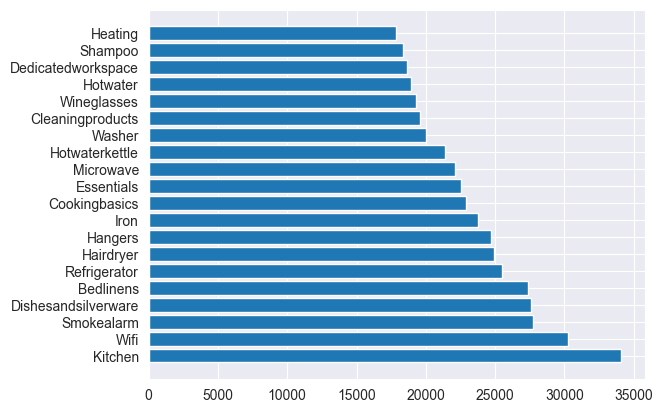

dict_keys(['Kitchen', 'Wifi', 'Smokealarm', 'Dishesandsilverware', 'Bedlinens', 'Refrigerator', 'Hairdryer', 'Hangers', 'Iron', 'Cookingbasics', 'Essentials', 'Microwave', 'Hotwaterkettle', 'Washer', 'Cleaningproducts', 'Wineglasses', 'Hotwater', 'Dedicatedworkspace', 'Shampoo', 'Heating'])


In [2]:
# Plot distribution of df['amenities'].unique()
import matplotlib.pyplot as plt

uniques = {}
for i in df['amenities']:
    for j in i.split(','):
        if j in uniques:
            uniques[j] += 1
        else:
            uniques[j] = 1
print(f"Uniques: {len(uniques)}")
# Keep only the top 20
uniques = {k.replace(" ", ''): v for k, v in sorted(uniques.items(), key=lambda item: item[1], reverse=True)[:20]}
print(f"Uniques: {len(uniques)}")
# plot with labels horizontaly
plt.barh(list(uniques.keys()), list(uniques.values()))
plt.show()
print(uniques.keys())

In [15]:
def preprocess_data(df):
    """
    'id', 'room_type', 'price', 'availability_365', 'longitude', 'latitude',
       'property_type', 'room_type.1', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'amenities', 'availability_30', 'availability_60',
       'availability_90', 'availability_365.1', 'number_of_rooms', 'surface',
       'price_per_m2'

    'Kitchen', 'Wifi', 'Smokealarm', 'Dishesandsilverware', 'Bedlinens', 'Refrigerator', 'Hairdryer', 'Hangers', 'Iron', 'Cookingbasics', 'Essentials', 'Microwave', 'Hotwaterkettle', 'Washer', 'Cleaningproducts', 'Wineglasses', 'Hotwater', 'Dedicatedworkspace', 'Shampoo', 'Heating'
    """
    print("Start preprocess data")
    print("Drop columns")
    center_lat = df['latitude'].mean()
    center_lon = df['longitude'].mean()

    df['latitude'] = (df['latitude'] - center_lat)*(df['latitude'].max() - df['latitude'].min())
    df['longitude'] = (df['longitude'] - center_lon)*(df['longitude'].max() - df['longitude'].min())
    X = df.drop(
        ['id', 'room_type', 'room_type.1', 'property_type', 'availability_365.1', 'availability_30', 'availability_60',
         'availability_90', 'availability_365', 'price_per_m2', 'surface'],
        axis=1)
    # amenities: split by ',', to hot encode
    # print("Process amenities")
    #
    # amenities_old = X['amenities']
    # # create a raw df with uniques.keys() as columns
    # amenities = pd.DataFrame()
    # for k in uniques.keys():
    #     amenities[k] = amenities_old.apply(lambda x: 1 if k in x else 0)
    #
    # print("Concat amenities")
    # X = pd.concat([X, amenities], axis=1)
    print("Drop amenities")
    X = X.drop(['amenities'], axis=1)

    return X

In [16]:
def evaluate_model(train, test, model_name, model_display_name, model_class, model_params):
    X_train, y_train = train.drop(['price'], axis=1), train['price']
    X_test, y_test = test.drop(['price'], axis=1), test['price']
    print("Instantiate model")
    model = model_class(**model_params)
    print("Fit model")
    model.fit(X_train, y_train)
    print("Predict model")
    y_pred = model.predict(X_test)

    print("Mean squared error")
    mse = mean_squared_error(y_test, y_pred)
    print(f'{model_display_name} MSE: {mse:.2f}')
    print("Drawing results statistics")
    print("Accuracy score")
    print(f'{model_display_name} Accuracy: {model.score(X_test, y_test):.2f}')
    mm = y_test - y_pred
    print(mm.mean())
    return {
        'model': model_name,
        'mse': mse,
        'model_params': model_params,
    }

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df1 = preprocess_data(df)

Start preprocess data
Drop columns
Drop amenities


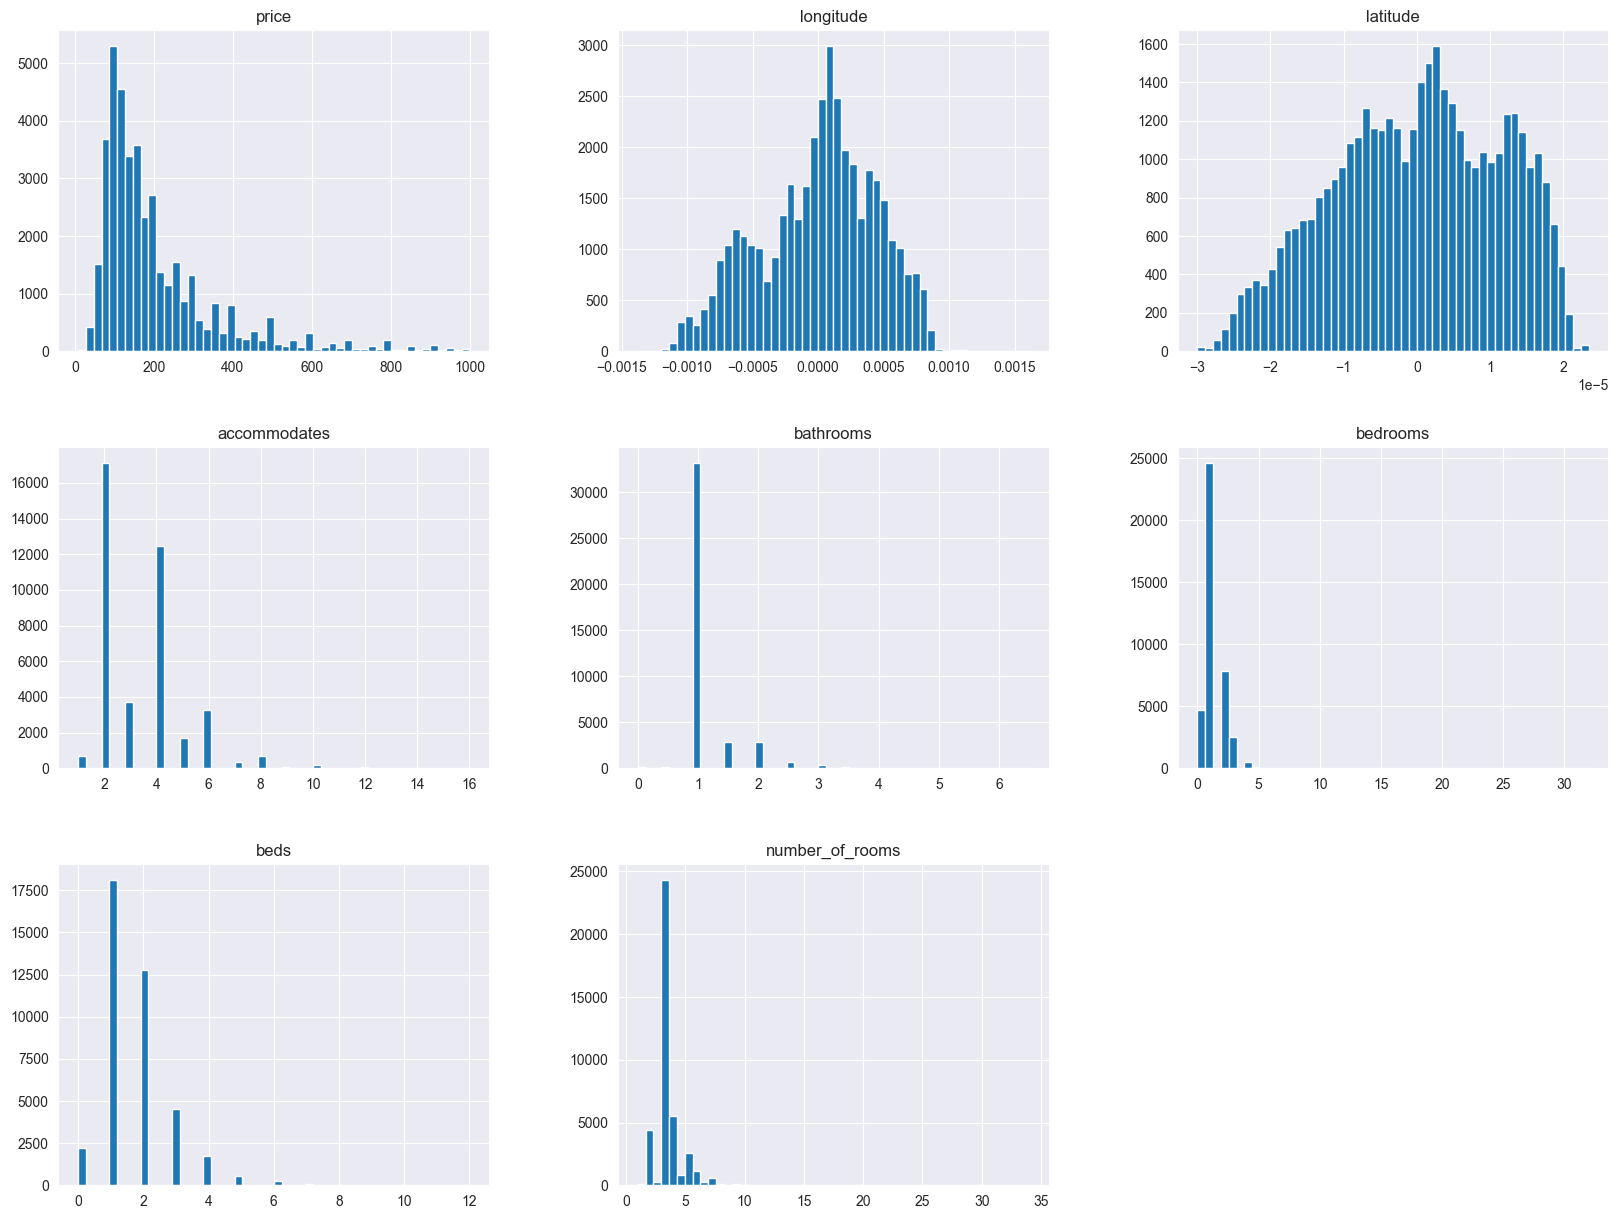

In [18]:
# Draw distribution of each column in df1
df1.hist(bins=50, figsize=(20, 15))
plt.show()

In [19]:
df1_train, df1_test = train_test_split(df1, test_size=0.2, random_state=42)
print(f"Train shape: {df1_train.shape}")
print(df1_train.head())

Train shape: (32268, 8)
       price  longitude      latitude  accommodates  bathrooms  bedrooms  \
3142   300.0   0.000249  1.197658e-05             2        1.0       1.0   
18272   99.0   0.000111  1.283043e-05             2        1.0       1.0   
33924  100.0  -0.000169  1.611012e-05             2        1.0       1.0   
39513  360.0  -0.000013  9.913605e-07             4        1.0       2.0   
2306   169.0   0.000577 -7.061073e-06             4        1.0       1.0   

       beds  number_of_rooms  
3142    1.0              3.0  
18272   1.0              3.0  
33924   1.0              3.0  
39513   2.0              4.0  
2306    2.0              3.0  


In [20]:
print(df1_train)

       price  longitude      latitude  accommodates  bathrooms  bedrooms  \
3142   300.0   0.000249  1.197658e-05             2        1.0       1.0   
18272   99.0   0.000111  1.283043e-05             2        1.0       1.0   
33924  100.0  -0.000169  1.611012e-05             2        1.0       1.0   
39513  360.0  -0.000013  9.913605e-07             4        1.0       2.0   
2306   169.0   0.000577 -7.061073e-06             4        1.0       1.0   
...      ...        ...           ...           ...        ...       ...   
6265    92.0  -0.000448 -1.562241e-05             4        1.0       1.0   
11284  108.0   0.000423  2.415305e-06             3        1.0       1.0   
38158  109.0   0.000273  3.665871e-06             4        1.0       1.0   
860    180.0   0.000195  6.178472e-06             4        1.0       2.0   
15795  266.0   0.000019 -1.665719e-06             4        1.0       1.0   

       beds  number_of_rooms  
3142    1.0              3.0  
18272   1.0              

In [21]:
from sklearn.svm import SVR

model = SVR

model_params = {
    'kernel': 'linear',
    'C': 1.0,
    'epsilon': 0.01
}

evaluate_model(df1_train, df1_test, 'svr', 'SVR', model, model_params)

Instantiate model
Fit model
Predict model
Mean squared error
SVR MSE: 17573.69
Drawing results statistics
Accuracy score
SVR Accuracy: 0.26
33.45909908397736


{'model': 'svr',
 'mse': np.float64(17573.69452181921),
 'model_params': {'kernel': 'linear', 'C': 1.0, 'epsilon': 0.01}}

In [25]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression

model_params = {
    'fit_intercept': True
}

evaluate_model(df1_train, df1_test, 'linear_regression', 'Linear Regression', model, model_params)

Instantiate model
Fit model
Predict model
Mean squared error
Linear Regression MSE: 20396.15
Drawing results statistics
Accuracy score
Linear Regression Accuracy: 0.04
41.12555775904809


C:\Users\hugue\Documents\CPE_TP\IA_et_Deep_Learning\TP1-20240927\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'model': 'linear_regression',
 'mse': np.float64(20396.14514129896),
 'model_params': {'fit_intercept': True}}

In [24]:
# Now using neural networks
from sklearn.neural_network import MLPRegressor

model = MLPRegressor

model_params = {
    'hidden_layer_sizes': (100,),
    'activation': 'relu',
}

evaluate_model(df1_train, df1_test, 'mlp', 'MLP', model, model_params)

Instantiate model
Fit model
Predict model
Mean squared error
MLP MSE: 15897.40
Drawing results statistics
Accuracy score
MLP Accuracy: 0.33
-3.448404158221873


C:\Users\hugue\Documents\CPE_TP\IA_et_Deep_Learning\TP1-20240927\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'model': 'mlp',
 'mse': np.float64(15897.395956691684),
 'model_params': {'hidden_layer_sizes': (100,), 'activation': 'relu'}}

In [23]:
#Mutli-layer neural network
from sklearn.neural_network import MLPClassifier

model = MLPClassifier

model_params = {

    'hidden_layer_sizes': (100, 100, 50),
    'activation': 'relu',
}

evaluate_model(df1_train, df1_test, 'mlp', 'MLP', model, model_params)

Instantiate model
Fit model


C:\Users\hugue\Documents\CPE_TP\IA_et_Deep_Learning\TP1-20240927\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Predict model
Mean squared error
MLP MSE: 20910.33
Drawing results statistics
Accuracy score
MLP Accuracy: 0.04
27.172409519087754


{'model': 'mlp',
 'mse': np.float64(20910.32535944472),
 'model_params': {'hidden_layer_sizes': (100, 100, 50), 'activation': 'relu'}}

In [13]:
!pip install tensorflow

In [22]:
# Using tensorflow keras

import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

X_train, y_train = df1_train.drop(['price'], axis=1), df1_train['price']
X_test, y_test = df1_test.drop(['price'], axis=1), df1_test['price']


model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=2)

Epoch 1/100
1009/1009 - 2s - 2ms/step - accuracy: 0.0000e+00 - loss: 27079.7129 - val_accuracy: 0.0000e+00 - val_loss: 16716.8008
Epoch 2/100
1009/1009 - 1s - 796us/step - accuracy: 0.0000e+00 - loss: 16996.1660 - val_accuracy: 0.0000e+00 - val_loss: 16623.9102
Epoch 3/100
1009/1009 - 1s - 834us/step - accuracy: 0.0000e+00 - loss: 16861.9473 - val_accuracy: 0.0000e+00 - val_loss: 16460.4785
Epoch 4/100
1009/1009 - 1s - 920us/step - accuracy: 0.0000e+00 - loss: 16762.5430 - val_accuracy: 0.0000e+00 - val_loss: 16420.5625
Epoch 5/100
1009/1009 - 1s - 855us/step - accuracy: 0.0000e+00 - loss: 16690.9707 - val_accuracy: 0.0000e+00 - val_loss: 16312.3701
Epoch 6/100
1009/1009 - 1s - 861us/step - accuracy: 0.0000e+00 - loss: 16647.3867 - val_accuracy: 0.0000e+00 - val_loss: 16276.4014
Epoch 7/100
1009/1009 - 1s - 827us/step - accuracy: 0.0000e+00 - loss: 16613.2188 - val_accuracy: 0.0000e+00 - val_loss: 16244.2061
Epoch 8/100


KeyboardInterrupt: 